In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt

from torch.distributions import Categorical, Normal

from sklearn.metrics import confusion_matrix, classification_report

from core import Critic, Actor, Episode, ReplayBuffer
from ud_sac import sample_episode

# Critic test

In [2]:
def _critic_loss(critic, num_classes, state, command, action, reward, next_state, done, output):
    with torch.no_grad():
        next_command = torch.zeros_like(command)

        next_command[:, 0] = command[:, 0] - reward
        next_command[:, 1] = torch.max(command[:, 1] - 1, torch.ones_like(command[:, 1]))

        next_action = critic.log_prob_by_action(next_state, next_command, next_command).argmax(dim=1)
        next_action = F.one_hot(next_action.long(), num_classes=num_classes)

        next_output = critic.sample(next_state, next_action, next_command)
        next_output[:, 1] = torch.round(next_output[:, 1])
        
        target_output = next_output + torch.cat([reward.view(-1, 1), torch.ones_like(reward).view(-1, 1)], dim=-1)

    Q_done = critic.log_prob(state, action, command, output)
    Q_not_done = critic.log_prob(state, action, command, target_output)        
    loss = -(done * Q_done + (1 - done) * Q_not_done).mean() # NLL

    return loss


def sample_random_batch(env_name, warmup_episodes=100, buffer_size=100, batch_size=5000):    
    env = gym.make(env_name)
    buffer = ReplayBuffer(size=buffer_size)
    
    for _ in range(warmup_episodes):
        episode = sample_episode(env, None, None)
        buffer.add(episode)
      
    batch = buffer.sample(batch_size)

    states, actions, rewards, commands, next_states, dones, outputs = [], [], [], [], [], [], []

    for episode in batch:
        T = episode.length

        t1 = np.random.randint(0, T)
        t2 = int(T) # take only full run
        dr = np.sum(episode.rewards[t1:t2])
        dh = t2-t1

        states.append(episode.states[t1])
        actions.append(episode.actions[t1])
        rewards.append(episode.rewards[t1])
        commands.append(episode.commands[t1])
        next_states.append(episode.next_states[t1])
        dones.append(episode.dones[t1])
        outputs.append([dr, dh])
    
    return [states, commands, actions, rewards, next_states, dones, outputs]

In [3]:
state, command, action, reward, next_state, done, output = sample_random_batch("LunarLander-v2")

state = torch.tensor(state, dtype=torch.float32)
command = torch.tensor(command, dtype=torch.float32)

action = torch.tensor(action, dtype=torch.float32)
action = F.one_hot(action.long(), num_classes=4)

reward = torch.tensor(reward, dtype=torch.float32)
next_state = torch.tensor(next_state, dtype=torch.float32)
done = torch.tensor(done, dtype=torch.float32)
output = torch.tensor(output, dtype=torch.float32)

In [110]:
output.mean(dim=0)

tensor([-152.0836,   51.6738])

In [5]:
critic = Critic(8, 4, 2, n_heads=20)
critic_optim = torch.optim.Adam(critic.parameters())

In [6]:
for epoch in range(5000):    
    loss = critic.nll_loss(state, command, action, output)
#     loss = _critic_loss(critic, 4, state, command, action, reward, next_state, done, output)
    
    if epoch % 100 == 0:
        print(loss.item())
    
    critic_optim.zero_grad()
    loss.backward()
    critic_optim.step()

176.69354248046875
11.908214569091797
10.819160461425781
10.38652229309082
10.217586517333984
10.093171119689941
10.008441925048828
9.947525024414062
9.902153968811035
9.864594459533691
9.830892562866211
9.798434257507324
9.780509948730469
9.73519229888916
9.698724746704102
9.65687084197998
9.616429328918457
9.55778694152832
9.498537063598633
9.440113067626953
9.372452735900879
9.3134183883667
9.265549659729004
9.180081367492676
9.116965293884277
11.288261413574219
9.679909706115723
9.500120162963867
9.415987014770508
9.351606369018555
9.296290397644043
9.241689682006836
9.187156677246094
9.138375282287598
9.054255485534668
8.947656631469727
8.852184295654297
8.778434753417969
8.724838256835938
8.842141151428223
8.592974662780762
8.52952766418457
8.533177375793457
8.447999954223633
8.732566833496094
8.382889747619629
8.353883743286133
8.319585800170898
8.74255657196045
8.26171875


tensor([-207.3390,   61.8455])


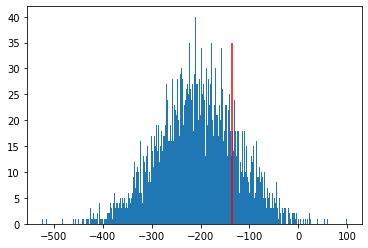

In [8]:
sample = [critic.sample(state[1].unsqueeze(0), command[1].unsqueeze(0), action[1].unsqueeze(0)) for _ in range(5000)]

print(torch.cat(sample).mean(dim=0))

plt.hist(torch.cat(sample)[:, 0].numpy(), bins=600);
plt.vlines(output[1][0], 0, 35, colors="red");

In [9]:
def episode_stats(env_name, critic, actor=None, controller=None):
    episode = sample_episode(gym.make(env_name), actor, controller)

    state = torch.tensor(episode.states, dtype=torch.float32)
    command = torch.tensor(episode.commands, dtype=torch.float32)

    action = torch.tensor(episode.actions, dtype=torch.float32)
    action = F.one_hot(action.long(), num_classes=4)
    
    episode_x = torch.cat([state, command, action], dim=1)

    log_alpha, mu, sigma = critic.model(episode_x)

    for i in range(int(episode.length)):
        output_h = int(episode.length) - i
        output_r = np.sum(episode.rewards[i:])

        pred_mean = critic.mean(state[i].unsqueeze(0), command[i].unsqueeze(0), action[i].unsqueeze(0))[0]
            
        print(f"Step {i} " + "=" * 50)
        print(f"Outcome: {[output_r, output_h]}") 
        print(f"Predicted outcome means: {pred_mean.detach().numpy()}")
        print(f"Mixture means:\n {mu[i].detach().numpy()}")
        print(f"Mixture stds:\n {sigma[i].detach().numpy()}")
        print()

In [10]:
# %%capture cap --no-stderr
episode_stats(env_name="LunarLander-v2", critic=critic)

Step 0 ==================================================
Outcome: [-102.61790600998661, 91]
Predicted outcome means: [-159.3224    75.83536]
Mixture means:
 [[   2.113532    14.2256775]
 [  10.411433    19.489279 ]
 [ -10.064434    -4.228605 ]
 [ -47.342785    56.24568  ]
 [  -9.207039     4.5758533]
 [-285.98123     86.45598  ]
 [  -6.6020765    7.41804  ]
 [ -32.877163    62.73461  ]
 [-445.26404     47.294937 ]
 [-106.50667     32.25469  ]
 [-122.729996    72.35203  ]
 [ -36.01134     25.249535 ]
 [  -1.466615     6.0843797]
 [   9.5345955   -4.0862794]
 [  -4.651415    -2.8289003]
 [ -26.504807     5.5814724]
 [ -12.405144  1155.7714   ]
 [ -99.466194    52.104332 ]
 [   3.210766    36.52627  ]
 [-347.9041      67.6262   ]]
Mixture stds:
 [[1.35335281e-01 1.35335281e-01]
 [1.35335281e-01 7.84167051e-01]
 [1.35335281e-01 1.35335281e-01]
 [1.12762062e+06 5.81969070e+00]
 [1.35335281e-01 9.17429443e+02]
 [7.90715942e+01 6.19087839e+00]
 [1.35335281e-01 1.18776234e+05]
 [4.85165184e+0

Step 28 ==================================================
Outcome: [-102.95941541784048, 63]
Predicted outcome means: [-93.47604   50.906723]
Mixture means:
 [[ 1.13383949e+00  1.26099663e+01]
 [ 9.56296825e+00  1.87834167e+01]
 [-8.69327354e+00 -4.55301714e+00]
 [-2.98447361e+01  4.76118202e+01]
 [-7.61688423e+00  3.29736519e+00]
 [-1.84202255e+02  7.44837265e+01]
 [-5.89080572e+00  6.17451525e+00]
 [-2.99518795e+01  5.35549507e+01]
 [-4.42849548e+02  4.37647324e+01]
 [-7.83295517e+01  1.24126348e+01]
 [-9.32187500e+01  5.08412552e+01]
 [-3.30696220e+01  2.13009682e+01]
 [-3.78192806e+00  6.55303621e+00]
 [ 8.76176357e+00 -4.69692659e+00]
 [-2.39066505e+00 -9.34738219e-01]
 [-2.48712330e+01  4.50077486e+00]
 [-1.08840923e+01  1.02383057e+03]
 [-9.13973236e+01  3.34874153e+01]
 [ 3.51077127e+00  3.42993088e+01]
 [-2.98420227e+02  6.11784134e+01]]
Mixture stds:
 [[1.3533528e-01 1.3533528e-01]
 [1.3533528e-01 1.3061107e+00]
 [1.3533528e-01 1.3533528e-01]
 [4.6587603e+05 2.2653067e+00]
 

Step 68 ==================================================
Outcome: [-101.67199678380014, 23]
Predicted outcome means: [-84.828674  13.613576]
Mixture means:
 [[ 6.0409941e-02  1.0552803e+01]
 [ 1.0152134e+01  1.8367876e+01]
 [-6.3949914e+00 -6.4494629e+00]
 [-9.6406536e+00  4.2078842e+01]
 [-4.9663482e+00  1.5007812e+00]
 [-7.7772102e+01  3.7557476e+01]
 [-5.4450021e+00  5.0313878e+00]
 [-2.8343811e+01  4.4178509e+01]
 [-4.5972574e+02  3.6138176e+01]
 [-4.9019413e+01 -2.0119093e+01]
 [-8.4826645e+01  1.3611601e+01]
 [-3.0066666e+01  1.8397650e+01]
 [-7.2704949e+00  7.3840618e+00]
 [ 7.4080296e+00 -5.8041234e+00]
 [ 9.8560524e-01  2.8197086e-01]
 [-2.2509680e+01  2.1588979e+00]
 [-6.6362658e+00  8.8608026e+02]
 [-8.9927864e+01  4.7779293e+00]
 [ 3.4185903e+00  3.1130535e+01]
 [-2.4918460e+02  5.4340290e+01]]
Mixture stds:
 [[1.3533528e-01 1.3533528e-01]
 [1.3533528e-01 7.8127017e+00]
 [1.3533528e-01 1.3533528e-01]
 [8.7314820e+04 7.2192764e-01]
 [1.3533528e-01 4.4430008e+00]
 [1.436677

In [11]:
def rollout(actor, desired_return, desired_horizon):
    env = gym.make("LunarLander-v2")

    state, done = env.reset(), False
    
    total_return, steps = 0.0, 0.0
    while not done:
        command = np.array([desired_return, desired_horizon])
        
        action = actor.act(state, command)
        state, reward, done, _ = env.step(action)
        
        desired_return = min(desired_return - reward, env.reward_range[1])
        desired_horizon = max(desired_horizon - 1, 1)
        
        total_return += reward
        steps += 1
        
    return total_return, steps

# Actor test

In [12]:
def _actor_loss(actor, critic, state, command):
    _, action_probs, action_log_probs = actor(state, command, return_probs=True)
    Q_target = critic.log_prob_by_action(state, command, output=command)

    loss = ((0.2 * action_log_probs - Q_target.detach()) * action_probs).sum(dim=1).mean()

    return loss

In [14]:
command.mean(dim=0)

tensor([-134.4861,   47.9178])

In [15]:
actor = Actor(8, 4)
actor_optim = torch.optim.Adam(actor.parameters())

In [16]:
for epoch in range(5000):    
    actor_loss = _actor_loss(actor, critic, state, command)
    
    if epoch % 100 == 0:
        print(actor_loss.item())
    
    actor_optim.zero_grad()
    actor_loss.backward()
    actor_optim.step()

14.053292274475098
13.797418594360352
13.764531135559082
13.745965957641602
13.74161434173584
13.739407539367676
13.738009452819824
13.73594856262207
13.734947204589844
13.733942031860352
13.733068466186523
13.732404708862305
13.7323579788208
13.731865882873535
13.731379508972168
13.7315092086792
13.730603218078613
13.730781555175781
13.730118751525879
13.729903221130371
13.729732513427734
13.729859352111816
13.729443550109863
13.729455947875977
13.729162216186523
13.728865623474121
13.72892951965332
13.728548049926758
13.72826099395752
13.736684799194336
13.728962898254395
13.728703498840332
13.728496551513672
13.728435516357422
13.728371620178223
13.7284517288208
13.72835636138916
13.728229522705078
13.72854995727539
13.72807502746582
13.728601455688477
13.728107452392578
13.72814655303955
13.726806640625
13.724884033203125
13.72495174407959
13.724981307983398
13.724720001220703
13.72498607635498
13.724611282348633


In [17]:
confusion_matrix(critic.log_prob_by_action(state, command, command).argmax(dim=1).numpy(), actor(state, command).numpy())

array([[ 139,   38,   41,   32],
       [ 200,  864,  125,  241],
       [ 245,  240, 1562,  261],
       [ 180,  198,  133,  501]])

In [18]:
print(classification_report(critic.log_prob_by_action(state, command, command).argmax(dim=1).numpy(), actor(state, command).numpy()))

              precision    recall  f1-score   support

           0       0.18      0.55      0.27       250
           1       0.66      0.61      0.63      1430
           2       0.83      0.67      0.74      2308
           3       0.50      0.52      0.51      1012

    accuracy                           0.61      5000
   macro avg       0.54      0.59      0.54      5000
weighted avg       0.68      0.61      0.64      5000



In [19]:
class TestActor:
    def __init__(self, actor):
        self.actor = actor
        
    def act(self, state, command, eval_mode=False):
        with torch.no_grad():
            state = torch.tensor(state, dtype=torch.float32)
            command = torch.tensor(command, dtype=torch.float32) 

            action = self.actor(state, command, eval_mode=eval_mode)
            
        return action.cpu().numpy().item()

In [80]:
test_actor = TestActor(actor)

In [116]:
desired_rewards = np.sort(np.random.uniform(-200, -100, size=500))

In [117]:
rewards = [np.mean([rollout(test_actor, r, 50)[0] for _ in range(5)]) for r in desired_rewards]

Text(0, 0.5, 'Actual rewards')

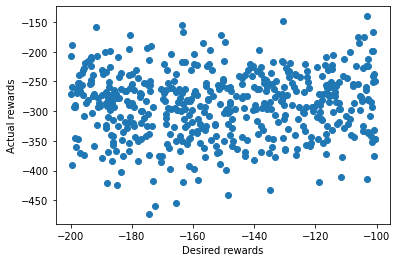

In [120]:
plt.scatter(desired_rewards, rewards)
plt.xlabel("Desired rewards")
plt.ylabel("Actual rewards")